# Amazon Fine Food Reviews Analysis Using Logistic Regression


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [43]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# [1]. Reading Data

In [44]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\\TGM\\ML\\AmazonFineFoodReviews\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [45]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [46]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [47]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [48]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [49]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [50]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [51]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [52]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [53]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [54]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [55]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())


(87773, 10)
1    73592
0    14181
Name: Score, dtype: int64


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [56]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [57]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [58]:
sent_4900 = decontracted(sent_4900)
print(sent_4900)
print("="*50)

My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, do not get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon is price was much more reasonable than any other retailer. You can buy a 1 pound bag on Amazon for almost the same price as a 6 ounce bag at other retailers. It is definitely worth it to buy a big bag if your dog eats them a lot.


In [59]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [60]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [61]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [62]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:57<00:00, 1535.30it/s]


In [63]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [64]:
final['cleaned_text']=preprocessed_reviews

In [65]:
final.shape

(87773, 11)

In [66]:
final["Score"].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

In [67]:
#Sorted the data based on time and took 100k data points
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,2003-10-25,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",nothing product bother link top page buy used ...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,2003-10-25,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff sugar free not rot gums tastes good...


In [68]:
Y = final['Score'].values
X = final['cleaned_text'].values
print(Y.shape)
print(type(Y))
print(X.shape)
print(type(X))

(87773,)
<class 'numpy.ndarray'>
(87773,)
<class 'numpy.ndarray'>


In [69]:
# split the data set into train and test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y,test_size=0.3, random_state=12, shuffle = False)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X,Y, test_size=0.3, random_state=12, shuffle = False)

print('='*100)
print("After splitting")
print("X_Train Shape:",X_Train.shape, "Y_Train Shape:",Y_Train.shape)
print("X_cv Shape:",X_cv.shape,       "Y_cv Shape",Y_cv.shape)
print("X_Test Shape",X_Test.shape,    "Y_Test Shape",Y_Test.shape)

After splitting
X_Train Shape: (61441,) Y_Train Shape: (61441,)
X_cv Shape: (26332,) Y_cv Shape (26332,)
X_Test Shape (26332,) Y_Test Shape (26332,)


<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

# [4] Featurization

## [4.1] BAG OF WORDS

In [70]:
#BoW
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
count_vect.fit(X_Train)
print("some feature names ", count_vect.get_feature_names()[:10])
X_Train_Bow = count_vect.transform(X_Train)
X_Test_Bow = count_vect.transform(X_Test)
X_CV_Bow = count_vect.transform(X_cv)

print('='*50)

#final_counts = count_vect.transform(X_Test)

print("the type of X Train : ",type(X_Train_Bow))
print("the shape of Train BOW vectorizer ",X_Train_Bow.get_shape())
print("the shape of Test BOW vectorizer ",X_Test_Bow.get_shape())
print("the shape of CV BOW vectorizer ",X_CV_Bow.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aa dark', 'aa extra', 'aa kona', 'aa may', 'aa not', 'aa part', 'aa quality', 'aa really', 'aa rich']
the type of X Train :  <class 'scipy.sparse.csr.csr_matrix'>
the shape of Train BOW vectorizer  (61441, 1071615)
the shape of Test BOW vectorizer  (26332, 1071615)
the shape of CV BOW vectorizer  (26332, 1071615)


In [71]:
def Optimal_Lamda_L1(X_Train,Y_Train,X_CV,Y_CV):
    train_AUC_L1 = [] 
    CV_AUC_L1 = []
    cv_scores = []
    tuned_parameters=[10**-4, 10**-3, 10**-2, 10**-1, 1,10**1, 10**2, 10**3, 10**4]
    for j in  tqdm(tuned_parameters):
        LR_Model = LogisticRegression(C=j, penalty= 'l1', class_weight='balanced')
        LR_Model.fit(X_Train, Y_Train)
        y_train_pred =  LR_Model.predict_proba(X_Train)[:,1] 
        y_cv_pred =  LR_Model.predict_proba(X_CV)[:,1]
        train_AUC_L1.append(roc_auc_score(Y_Train,y_train_pred)) 
        CV_AUC_L1.append(roc_auc_score(Y_CV, y_cv_pred))
                
    #Error plots with penaly L1
    plt.plot(np.log(tuned_parameters), train_AUC_L1, label='Train AUC-L1') 
    plt.plot(np.log(tuned_parameters), CV_AUC_L1, label='CV AUC-L1')
    plt.legend()
    plt.xlabel("Hyperparameter (Lambda)")
    plt.ylabel("AUC")
    plt.title("AUC PLOT")
    plt.show()
    
    #Cv auc scores with penalty L1
    print("CV AUS Scores with Penalty=? Cv auc scores with penalty L1")
    print(CV_AUC_L1)
    print("Maximun AUC value :",max(CV_AUC_L1))
    print("Index",CV_AUC_L1.index(max(CV_AUC_L1)))    

In [76]:
def Optimal_Lamda_L2(X_Train,Y_Train,X_CV,Y_CV):
    train_AUC_L2 = [] 
    CV_AUC_L2 = []
    cv_scores = []
    tuned_parameters=[10**-4, 10**-3, 10**-2, 10**-1, 1,10**1, 10**2, 10**3, 10**4]
    for j in  tqdm(tuned_parameters):
        LR_Model = LogisticRegression(C=j, penalty= 'l2', class_weight='balanced')
        LR_Model.fit(X_Train, Y_Train)
        y_train_pred =  LR_Model.predict_proba(X_Train)[:,1] 
        y_cv_pred =  LR_Model.predict_proba(X_CV)[:,1]
        train_AUC_L2.append(roc_auc_score(Y_Train,y_train_pred)) 
        CV_AUC_L2.append(roc_auc_score(Y_CV, y_cv_pred))
                 
    #Error plots with penaly L2
    plt.plot(np.log(tuned_parameters), train_AUC_L2, label='Train AUC-L2') 
    plt.plot(np.log(tuned_parameters), CV_AUC_L2, label='CV AUC-L2')
    plt.legend()
    plt.xlabel("Hyperparameter (Lambda)")
    plt.ylabel("AUC")
    plt.title("AUC PLOT")
    plt.show()
    
    #Cv auc scores with penalty L2
    print("Cv AUC scores with penalty L2")
    print(CV_AUC_L2)
    print("Maximun AUC value :",max(CV_AUC_L2))
    print("Index",CV_AUC_L2.index(max(CV_AUC_L2)))    

### <font color=blue>[4.1.1] Hyperparameter tuning with L1 Regulizer and AUC Curve Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:51<00:00,  7.13s/it]


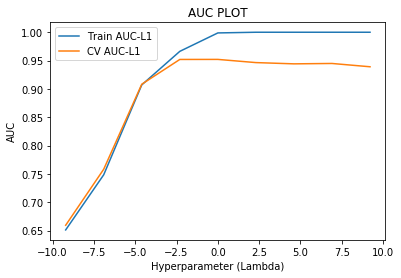

CV AUS Scores with Penalty=? Cv auc scores with penalty L1
[0.6593160898298803, 0.7582264148946865, 0.9082536827182264, 0.9519717158371811, 0.9520599816534888, 0.946429487242473, 0.9442112574817713, 0.94488989699802, 0.9390566839676131]
Maximun AUC value : 0.9520599816534888
Index 4


In [74]:
Optimal_Lamda_L1(X_Train_Bow, Y_Train, X_CV_Bow,Y_cv)

### <font color=blue>[4.1.2] Hyperparameter with L2 Regulizer and AUC Curve Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:06<00:00, 38.83s/it]


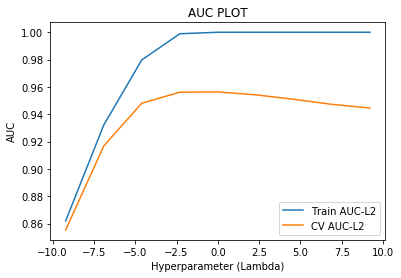

Cv AUC scores with penalty L2
[0.8554219433041911, 0.9168218360267333, 0.9480772065131374, 0.9561083225186672, 0.95635564014132, 0.9542159411077492, 0.9509292500378546, 0.9472551659084433, 0.9445847986985617]
Maximun AUC value : 0.95635564014132
Index 4


In [77]:
optimal_lambda_bow_l2 = Optimal_Lamda_L2(X_Train_Bow, Y_Train, X_CV_Bow,Y_cv)

### <font color = blue>[4.1.3] ROC Curve of Logistic Regression</font>

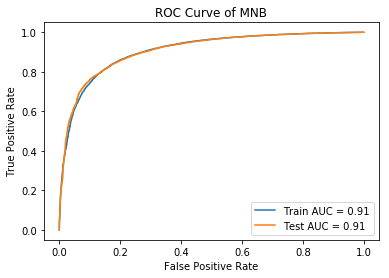

In [78]:
#Testing with test data
Optimal_Model = LogisticRegression(penalty='l1',C=0.01, class_weight='balanced')
Optimal_Model.fit(X_Train_Bow, Y_Train)
prediction = Optimal_Model.predict(X_Test_Bow)
Optimal_Model

Train_FPR, Train_TPR, threshold = roc_curve(Y_Train, Optimal_Model.predict_proba(X_Train_Bow)[:,1])
Test_FPR, Test_TPR, threshold = roc_curve(Y_Test, Optimal_Model.predict_proba(X_Test_Bow)[:,1])
roc_auc = auc(Train_FPR, Train_TPR)
roc_auc1 = auc(Test_FPR, Test_TPR)

plt.plot(Train_FPR, Train_TPR, label = 'Train AUC = %0.2f' % roc_auc)
plt.plot(Test_FPR, Test_TPR, label = 'Test AUC = %0.2f' % roc_auc1)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MNB')
plt.show()

### <font color = blue>[4.1.4]Train and Test Accuracy</font>

In [79]:
Training_Accuracy_Bow = Optimal_Model.score(X_Train_Bow, Y_Train)
print('Training_Accuracy=%0.3f'%Training_Accuracy_Bow)
Training_Error_Bow = 1 - Training_Accuracy_Bow
print('Training_Error=%0.3f'%Training_Error_Bow)

Test_Accuracy_Bow = accuracy_score(Y_Test, prediction)
print('Test_Accuracy=%0.3f'%Test_Accuracy_Bow)
Test_Error_Bow = 1 - Test_Accuracy_Bow
print('Test_Error=%0.3f'%Test_Error_Bow)
#print('\nThe accuracy of the MNB classifier for k = %d is %f%%' % (optimal_alpha_bow, Test_Accuracy_Bow))

Training_Accuracy=0.830
Training_Error=0.170
Test_Accuracy=0.825
Test_Error=0.175


### <font color = blue>[4.1.5] Confusion Matrix </font>

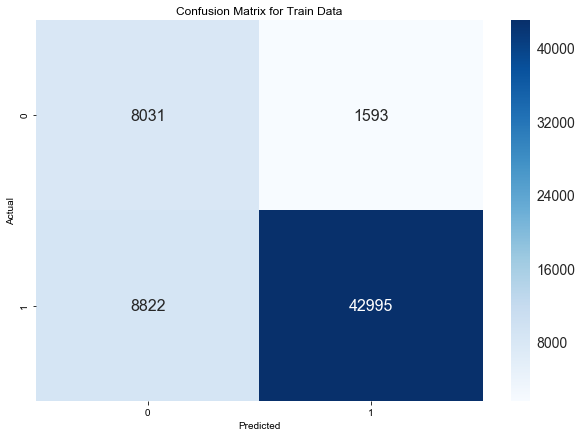

In [80]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Train, Optimal_Model.predict(X_Train_Bow))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Train), index=np.unique(Y_Train))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Train Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

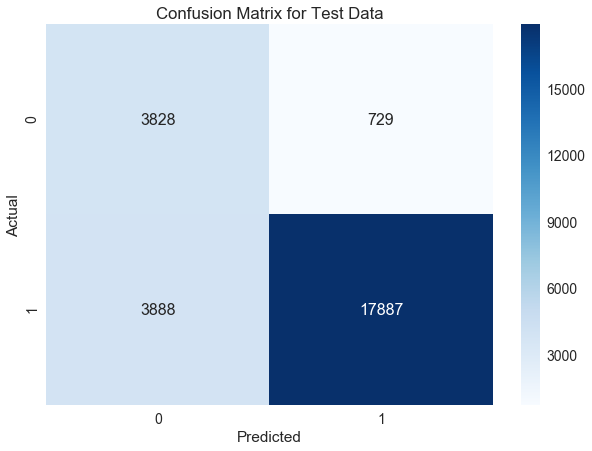

In [81]:
#With the reference of below link:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Test, Optimal_Model.predict(X_Test_Bow))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Test), index=np.unique(Y_Test))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Test Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

### <font color = blue>[4.1.6] Classification Report</font>

In [82]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test, prediction))

             precision    recall  f1-score   support

          0       0.50      0.84      0.62      4557
          1       0.96      0.82      0.89     21775

avg / total       0.88      0.82      0.84     26332



## <font color = Blue>[4.1.7] Feature Importance </font>

### <font color = blue>Feature Importance for Positive and Negetive Class</font>

In [83]:
#Multinomial NB: Most Informative Features
#Reference link: https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("________________________________________________________________________________________________")
    print("\tNegative\t\t\t\t\tPositive")    
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [84]:
show_most_informative_features(count_vect, Optimal_Model)

________________________________________________________________________________________________
	Negative					Positive
________________________________________________________________________________________________
	-1.0865	worst          				1.1727	delicious      
	-1.0580	disappointed   				1.0814	perfect        
	-0.9205	awful          				0.9393	great          
	-0.8941	disappointing  				0.9318	loves          
	-0.8834	not good       				0.9284	excellent      
	-0.8383	horrible       				0.8775	best           
	-0.8260	terrible       				0.8095	wonderful      
	-0.8040	unfortunately  				0.7320	easy           
	-0.7853	not buy        				0.7060	highly         
	-0.6799	money          				0.6591	nice           
	-0.6694	not recommend  				0.5981	favorite       
	-0.6288	waste          				0.5507	tasty          
	-0.6022	not worth      				0.5458	amazing        
	-0.5875	bad            				0.5438	love           
	-0.5607	thought        				0.5167	stores         
	-0.5594	stale    

## <font color = Blue>[4.1.8] Pertubation Test </font>

In [85]:
#Getting the weights W after fit your model with the data X
W1=Optimal_Model.coef_
print(W1.shape)

(1, 1071615)


In [86]:
#Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
import copy
X=copy.deepcopy(X_Train_Bow)
e=np.random.normal(0,0.01)
X.data = X.data + e
print(X.shape)

(61441, 1071615)


In [87]:
#We fit the model again on data X' and get the weights W' 
BOW_Model = LogisticRegression(C= 0.01, penalty= 'l1', class_weight='balanced')
BOW_Model.fit(X,Y_Train)
W2=BOW_Model.coef_
print(W2.shape)

(1, 1071615)


In [88]:
#Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
e=np.random.normal(0,0.01)
W1 = W1+e
W2 = W2+e

In [89]:
#find the % change between W and W', percentage_change_vector = (| (W-W') / (W) |)*100)
percentage_change_vector = np.abs((W2-W1)/W1)*100
print("Max Percentage Value: ",percentage_change_vector.max())
print("Min Percentage Value: ",percentage_change_vector.min())
print("Std Percentage Value: ",percentage_change_vector.std())

Max Percentage Value:  32.077349009566774
Min Percentage Value:  0.0
Std Percentage Value:  0.06808463529111797


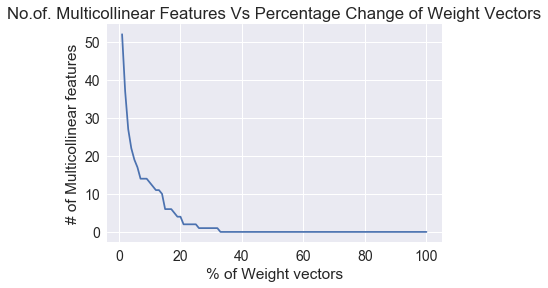

In [90]:
percentage_change=[]
collinear_features=[]

for i in range(1,101):
    f=np.where(percentage_change_vector > i)[1].size
    percentage_change.append(i)
    collinear_features.append(f)
    
plt.title('No.of. Multicollinear Features Vs Percentage Change of Weight Vectors')
plt.xlabel('% of Weight vectors')
plt.ylabel('# of Multicollinear features')
plt.plot(percentage_change,collinear_features)

In [96]:
Bow_feat=count_vect.get_feature_names()
reqd_feature = np.where(percentage_change_vector > 30)
print("No of features have weight changes greater than 30%: ", percentage_change_vector[reqd_feature].size)

features=[]
print("\nNames of the Multi-collinear features:\n")
for i in np.where(percentage_change_vector > 1)[1]:
    features.append(Bow_feat[i])
print(features)

No of features have weight changes greater than 30%:  1

Names of the Multi-collinear features:

['available', 'bars', 'beware', 'bitter', 'bottle', 'broken', 'calories', 'cheap', 'disgusting', 'earth', 'enjoyed', 'feel', 'gave', 'give', 'hoping', 'husband', 'instead', 'least', 'left', 'liked', 'looked', 'lot', 'may', 'might', 'mix', 'nasty', 'never', 'never buy', 'not bad', 'not disappointed', 'not even', 'not taste', 'often', 'pieces', 'please', 'problem', 'put', 'quick', 'quickly', 'quite', 'rather', 'recommended', 'refund', 'smell', 'sometimes', 'tastes like', 'texture', 'thanks', 'thinking', 'toy', 'two', 'unless']


## <font color=blue>[4.2] TF-IDF</font>

In [97]:
#TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit_transform(X_Train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_Train_TfIdf = tf_idf_vect.transform(X_Train)
X_Test_TfIdf = tf_idf_vect.transform(X_Test)
X_CV_TfIdf = tf_idf_vect.transform(X_cv)

#final_tf_idf = tf_idf_vect.transform(X_Test)
print("the type of count vectorizer ",type(X_Train_TfIdf))
print("the shape of out text TFIDF vectorizer ",X_Train_TfIdf.get_shape())
print("the shape of out text TFIDF vectorizer ",X_Test_TfIdf.get_shape())
print("the shape of out text TFIDF vectorizer ",X_CV_TfIdf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal pain', 'abide']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 80662)
the shape of out text TFIDF vectorizer  (26332, 80662)
the shape of out text TFIDF vectorizer  (26332, 80662)


### <font color=blue>[4.2.1] Hyperameter tuning with L1 Regulizer and AUC Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.70s/it]


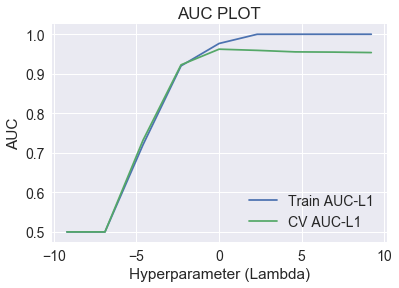

CV AUS Scores with Penalty=? Cv auc scores with penalty L1
[0.5, 0.5, 0.7319328359468673, 0.9226217320749269, 0.9622310939856851, 0.9592171113843857, 0.9553812645387032, 0.9548150773957226, 0.9536571711755699]
Maximun AUC value : 0.9622310939856851
Index 4


In [142]:
Optimal_Lamda_L1(X_Train_TfIdf, Y_Train, X_CV_TfIdf,Y_cv)

### <font color=blue>[4.2.2] Hyperameter tuning with L1 Regulizer and AUC Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  6.02s/it]


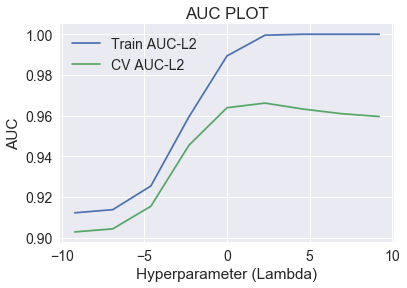

Cv AUC scores with penalty L2
[0.902931153721442, 0.9044393871025689, 0.9155399686632921, 0.9454701274606357, 0.9639196129546223, 0.9661884732412279, 0.9632519430497284, 0.9610109577700194, 0.9595892719518828]
Maximun AUC value : 0.9661884732412279
Index 5


In [143]:
optimal_lambda_tfidf_l2 = Optimal_Lamda_L2(X_Train_TfIdf, Y_Train, X_CV_TfIdf,Y_cv)

### <font color = blue>[4.2.3] ROC Curve of Logistic Regression</font>

In [101]:
#Testing with test data
Optimal_Model = LogisticRegression(penalty='l1',C=0.01, class_weight='balanced')
Optimal_Model.fit(X_Train_TfIdf, Y_Train)
prediction = Optimal_Model.predict(X_Test_TfIdf)
print('Optimal_Model',Optimal_Model)
print('prediction',prediction)

Optimal_Model LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
prediction [1 1 0 ... 1 1 1]


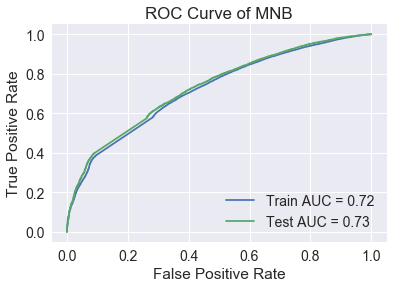

In [102]:
#Testing with test data
Train_FPR, Train_TPR, threshold = roc_curve(Y_Train, Optimal_Model.predict_proba(X_Train_TfIdf)[:,1])
Test_FPR, Test_TPR, threshold = roc_curve(Y_Test, Optimal_Model.predict_proba(X_Test_TfIdf)[:,1])
roc_auc2 = auc(Train_FPR, Train_TPR)
roc_auc3 = auc(Test_FPR, Test_TPR)

plt.plot(Train_FPR, Train_TPR, label = 'Train AUC = %0.2f' % roc_auc2)
plt.plot(Test_FPR, Test_TPR, label = 'Test AUC = %0.2f' % roc_auc3)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MNB')
plt.show()

### <font color = blue>[4.2.4]Train and Test Accuracy</font>

In [103]:
Training_Accuracy_Tfidf = Optimal_Model.score(X_Train_TfIdf, Y_Train)
print('Training_Accuracy=%0.3f'%Training_Accuracy_Tfidf)
Training_Error_Tfidf = 1 - Training_Accuracy_Tfidf
print('Training_Error=%0.3f'%Training_Error_Tfidf)

Test_Accuracy_Tfidf = accuracy_score(Y_Test, prediction)
print('Test_Accuracy=%0.3f'%Test_Accuracy_Tfidf)
Test_Error_Tfidf = 1 - Test_Accuracy_Tfidf
print('Test_Error=%0.3f'%Test_Error_Tfidf)
#print('\nThe accuracy of the MNB classifier for k = %d is %f%%' % (optimal_alpha_bow, Test_Accuracy_Bow))

Training_Accuracy=0.655
Training_Error=0.345
Test_Accuracy=0.652
Test_Error=0.348


### <font color = blue>[4.2.5] Confusion Matrix </font>

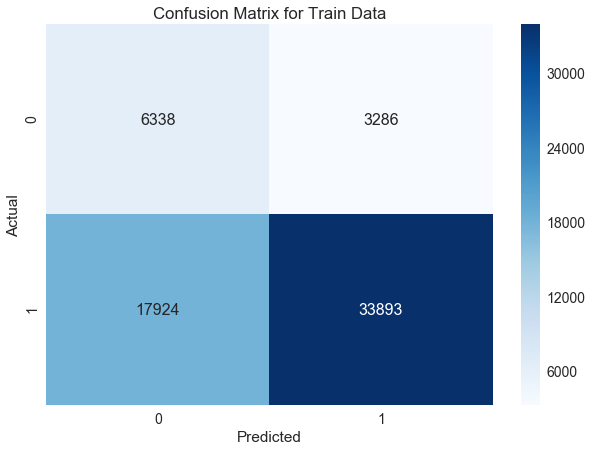

In [104]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Train, Optimal_Model.predict(X_Train_TfIdf))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Train), index=np.unique(Y_Train))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Train Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

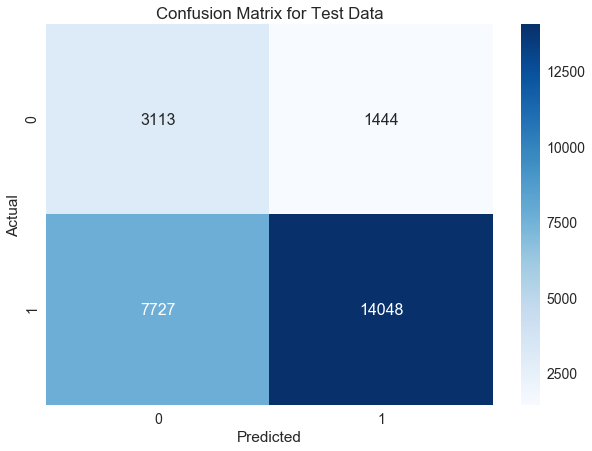

In [105]:
#With the reference of below link:
#https://www.kaggle.com/agungor2/various-confusion-matrix-plots
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Test, Optimal_Model.predict(X_Test_TfIdf))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Test), index=np.unique(Y_Test))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Test Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

### <font color = blue>[4.2.6] Classification Report</font>

In [106]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test, prediction))

             precision    recall  f1-score   support

          0       0.29      0.68      0.40      4557
          1       0.91      0.65      0.75     21775

avg / total       0.80      0.65      0.69     26332



## <font color = Blue>[4.2.7] Feature Importance </font>

### <font color = blue>Feature Importance for Positive and Negetive Class</font>	

In [107]:
show_most_informative_features(tf_idf_vect, Optimal_Model)

________________________________________________________________________________________________
	Negative					Positive
________________________________________________________________________________________________
	-10.3709	not            				8.5827	great          
	0.0000	aa             				1.7069	love           
	0.0000	aafco          				0.6437	best           
	0.0000	aback          				0.1810	good           
	0.0000	abandon        				0.0000	zukes mini     
	0.0000	abandoned      				0.0000	zukes          
	0.0000	abc            				0.0000	zuke treats    
	0.0000	abdomen        				0.0000	zuke minis     
	0.0000	abdominal      				0.0000	zuke mini      
	0.0000	abdominal pain 				0.0000	zuke hip       
	0.0000	abide          				0.0000	zuke           
	0.0000	abilities      				0.0000	zucchini       
	0.0000	ability        				0.0000	zoom           
	0.0000	abit           				0.0000	zoo            
	0.0000	able           				0.0000	zone bars      
	0.0000	able add       				0.00

## <font color = Blue>[4.2.7] Pertubation Test </font>

In [108]:
#Getting the weights W after fit your model with the data X
W1=Optimal_Model.coef_
print(W1.shape)

(1, 80662)


In [109]:
#Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
import copy
X=copy.deepcopy(X_Train_TfIdf)
e=np.random.normal(0,0.01)
X.data = X.data + e
print(X.shape)

(61441, 80662)


In [110]:
#We fit the model again on data X' and get the weights W' 
TFIDF_Model = LogisticRegression(C= 0.01, penalty= 'l1', class_weight='balanced')
TFIDF_Model.fit(X,Y_Train)
W2=TFIDF_Model.coef_
print(W2.shape)

(1, 80662)


In [111]:
#Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
e=np.random.normal(0,0.01)
W1 = W1+e
W2 = W2+e

In [112]:
#find the % change between W and W', percentage_change_vector = (| (W-W') / (W) |)*100)
percentage_change_vector = np.abs((W2-W1)/W1)*100
print("Max Percentage Value: ",percentage_change_vector.max())
print("Min Percentage Value: ",percentage_change_vector.min())
print("Std Percentage Value: ",percentage_change_vector.std())

Max Percentage Value:  99.91547108858693
Min Percentage Value:  0.0
Std Percentage Value:  0.5407848003679077


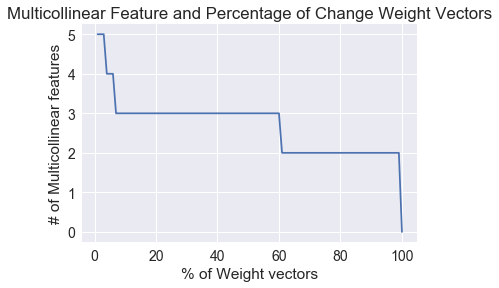

In [113]:
percentage_change=[]
collinear_features=[]

for i in range(1,101):
    f=np.where(percentage_change_vector > i)[1].size
    percentage_change.append(i)
    collinear_features.append(f)
    
plt.title('Multicollinear Feature and Percentage of Change Weight Vectors')
plt.xlabel('% of Weight vectors')
plt.ylabel('# of Multicollinear features')
plt.plot(percentage_change,collinear_features)

In [114]:
tfidf_feat=tf_idf_vect.get_feature_names()
reqd_feature = np.where(percentage_change_vector > 30)
print("No of features have weight changes greater than 30%: ", percentage_change_vector[reqd_feature].size)

features=[]
print("\nNames of the Multi-collinear features:\n")
for i in np.where(percentage_change_vector > 1)[1]:
    features.append(tfidf_feat[i])
print(features)

No of features have weight changes greater than 30%:  3

Names of the Multi-collinear features:

['best', 'good', 'great', 'love', 'not']


## <font color = Blue>[4.3]Word2Vec </font>

In [115]:
i=0
list_of_sentance_train=[]
for sentance in X_Train:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14799
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


### <font color = blue>[4.3.1] Computing avg w2v for train, test, and CV</font>

In [116]:
%%time
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [03:49<00:00, 268.14it/s]


(61441, 50)
[-0.33950951 -0.33488994 -0.33573298 -0.51396754 -0.06975959  0.21375592
  0.07732713 -0.60388593 -0.34814431  0.19845745  0.3815664   0.40204279
 -0.10928249  0.18389756  0.73805093  0.17999925 -0.12761659 -0.01847279
  0.53143276  0.26952201 -0.613577   -0.42093613  0.4640647  -0.42287367
 -0.15860972 -0.10623529 -0.40118239  0.15250288  0.16710049  0.62810433
  0.46918193  0.10473322 -0.45874493 -0.12482662  0.09535776 -0.09233927
 -0.1601373  -0.04365186  0.05148495  0.16999314 -0.37391493  0.27599862
  0.2095408  -0.04154568 -0.1154915  -0.11939497 -0.42355511 -0.4789842
 -0.01988444 -0.02846113]
Wall time: 3min 49s


In [117]:
%%time
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:55<00:00, 228.91it/s]


(26332, 50)
[-0.32212967 -0.05650922  0.85562827  0.80185549  1.38591885 -0.18607936
 -0.31209497 -0.51726579  0.0216198   0.3427079  -0.09292613 -0.15750389
  0.37896734 -0.08537286  0.04484537  0.72499551 -0.26671065  0.39521788
  0.65470891 -0.48425626  0.1468507  -0.2299341  -0.366834   -0.08889219
 -0.60205857 -0.54432607  0.28889598  0.55503118  0.06217408 -0.10286575
  0.82000878  0.0868873  -0.45831241  0.41500448 -0.3905572  -0.82853059
 -0.42346301 -0.39560083  0.28644322 -0.30447075 -0.14453179 -0.14473943
  0.79878876  1.36441523 -0.00346129  0.47505222 -0.51671918  0.6013452
 -0.0138015   0.70236979]
Wall time: 1min 55s


In [118]:
%%time

i=0
list_of_sentance_test=[]
for sentance in X_Test:
    list_of_sentance_test.append(sentance.split())
    
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [02:11<00:00, 200.37it/s]


(26332, 50)
[-0.32212967 -0.05650922  0.85562827  0.80185549  1.38591885 -0.18607936
 -0.31209497 -0.51726579  0.0216198   0.3427079  -0.09292613 -0.15750389
  0.37896734 -0.08537286  0.04484537  0.72499551 -0.26671065  0.39521788
  0.65470891 -0.48425626  0.1468507  -0.2299341  -0.366834   -0.08889219
 -0.60205857 -0.54432607  0.28889598  0.55503118  0.06217408 -0.10286575
  0.82000878  0.0868873  -0.45831241  0.41500448 -0.3905572  -0.82853059
 -0.42346301 -0.39560083  0.28644322 -0.30447075 -0.14453179 -0.14473943
  0.79878876  1.36441523 -0.00346129  0.47505222 -0.51671918  0.6013452
 -0.0138015   0.70236979]
Wall time: 2min 11s


### <font color=blue>[4.3.2] Hyperameter tuning with L1 Regulizer and AUC Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:30<00:00, 13.30s/it]


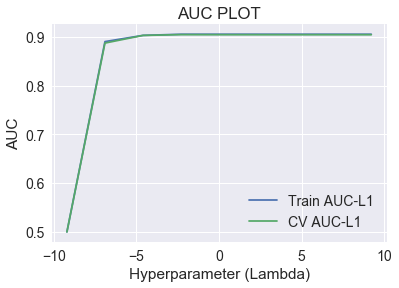

CV AUS Scores with Penalty=? Cv auc scores with penalty L1
[0.5, 0.8872852328220648, 0.9029992288015537, 0.9045686340163265, 0.9044482555067876, 0.904424341048593, 0.9044231821094053, 0.9044230813320847, 0.9044228092333189]
Maximun AUC value : 0.9045686340163265
Index 3


In [144]:
Optimal_Lamda_L1(sent_vectors_train, Y_Train, sent_vectors_cv,Y_cv)

### <font color=blue>[4.3.3] Hyperameter tuning with L2 Regulizer and AUC Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.85s/it]


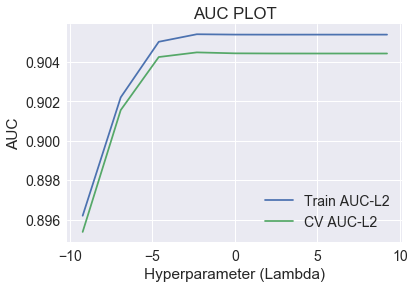

Cv AUC scores with penalty L2
[0.895374759362654, 0.9015520765544839, 0.9042422364301448, 0.9044777631062795, 0.9044299241121582, 0.9044226278341416, 0.9044210859411355, 0.9044212673403127, 0.904421337884437]
Maximun AUC value : 0.9044777631062795
Index 3


In [145]:
Optimal_Lamda_L2(sent_vectors_train, Y_Train, sent_vectors_cv,Y_cv)

### <font color = blue>[4.3.4] ROC Curve of Logistic Regression</font>

In [121]:
#Testing with test data
Optimal_Model = LogisticRegression(penalty='l1',C=0.01, class_weight='balanced')
Optimal_Model.fit(sent_vectors_train, Y_Train)
prediction = Optimal_Model.predict(sent_vectors_test)
print('Optimal_Model',Optimal_Model)
print('prediction',prediction)

Optimal_Model LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
prediction [1 1 1 ... 1 1 1]


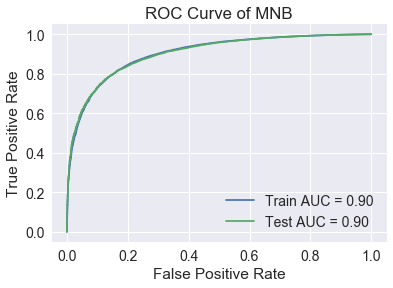

In [122]:
#Testing with test data
Train_FPR, Train_TPR, threshold = roc_curve(Y_Train, Optimal_Model.predict_proba(sent_vectors_train)[:,1])
Test_FPR, Test_TPR, threshold = roc_curve(Y_Test, Optimal_Model.predict_proba(sent_vectors_test)[:,1])
roc_auc4 = auc(Train_FPR, Train_TPR)
roc_auc5 = auc(Test_FPR, Test_TPR)

plt.plot(Train_FPR, Train_TPR, label = 'Train AUC = %0.2f' % roc_auc4)
plt.plot(Test_FPR, Test_TPR, label = 'Test AUC = %0.2f' % roc_auc5)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MNB')
plt.show()

### <font color = blue>[4.3.5]Train and Test Accuracy </font>

In [123]:
Training_Accuracy_w2v = Optimal_Model.score(sent_vectors_train, Y_Train)
print('Training_Accuracy=%0.3f'%Training_Accuracy_w2v)
Training_Error_w2v = 1 - Training_Accuracy_w2v
print('Training_Error=%0.3f'%Training_Error_w2v)

Test_Accuracy_w2v = accuracy_score(Y_Test, prediction)
print('Test_Accuracy=%0.3f'%Test_Accuracy_w2v)
Test_Error_w2v = 1 - Test_Accuracy_w2v
print('Test_Error=%0.3f'%Test_Error_w2v)
#print('\nThe accuracy of the MNB classifier for k = %d is %f%%' % (optimal_alpha_bow, Test_Accuracy_Bow))

Training_Accuracy=0.810
Training_Error=0.190
Test_Accuracy=0.806
Test_Error=0.194


### <font color = blue>[4.3.6]Confusion Matrix </font>

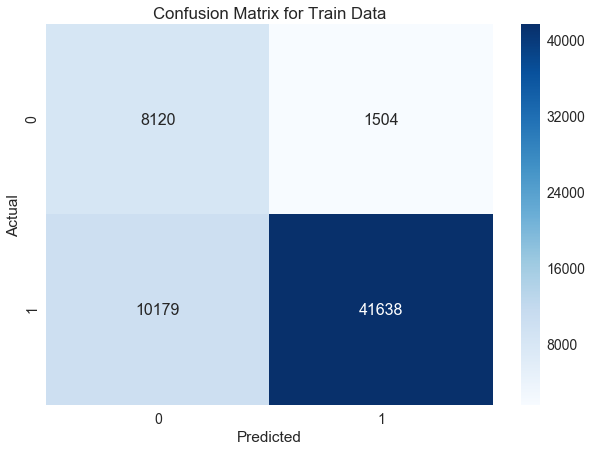

In [124]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Train, Optimal_Model.predict(sent_vectors_train))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Train), index=np.unique(Y_Train))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Train Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

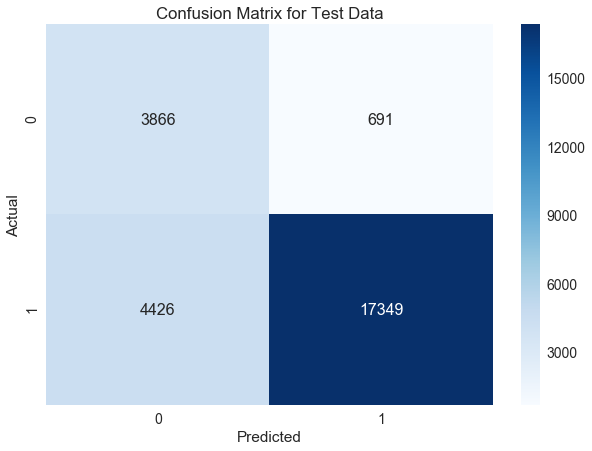

In [125]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Test, Optimal_Model.predict(sent_vectors_test))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Test), index=np.unique(Y_Test))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Test Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

### <font color = blue>[4.3.7] Classification Report</font>

In [126]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test, prediction))

             precision    recall  f1-score   support

          0       0.47      0.85      0.60      4557
          1       0.96      0.80      0.87     21775

avg / total       0.88      0.81      0.82     26332



## <font color = blue> [4.4] TFIDF weighted W2v </font>

In [127]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_Train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

### <font color = blue>[4.4.1] Compute TF-IDF weighted Word2Vec for Train, Test, and CV </font>

In [128]:
i=0
list_of_sentance_train=[]
for sentance in X_Train:
    list_of_sentance_train.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [48:36<00:00, 21.07it/s]


In [129]:
i=0
list_of_sentance_test=[]
for sentance in X_Test:
    list_of_sentance_test.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [21:22<00:00, 20.54it/s]


In [130]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [21:47<00:00, 20.15it/s]


### <font color=blue>[4.4.2] Hyperameter tuning with L1 Regulizer and AUC Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:55<00:00,  8.25s/it]


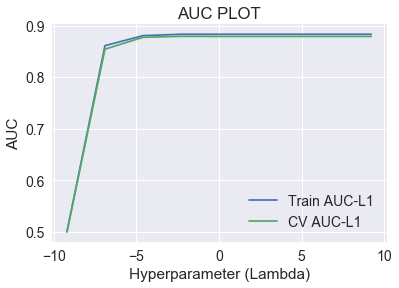

CV AUS Scores with Penalty=? Cv auc scores with penalty L1
[0.5, 0.8542753795714797, 0.8771947221909393, 0.8791301909453089, 0.8789090250373696, 0.8788800515576773, 0.8788779352339433, 0.8788774918137323, 0.8788775724355888]
Maximun AUC value : 0.8791301909453089
Index 3


In [131]:
Optimal_Lamda_L1(tfidf_sent_vectors_train, Y_Train, tfidf_sent_vectors_cv,Y_cv)

### <font color=blue>[4.4.3] Hyperameter tuning with L2 Regulizer and AUC Plot</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  2.05s/it]


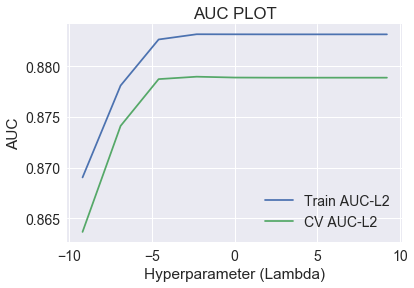

Cv AUC scores with penalty L2
[0.8636749004257086, 0.8741226364254082, 0.8787348314385937, 0.8789730589469223, 0.8788892122161259, 0.8788769778493968, 0.8788767359838272, 0.878876534429186, 0.8788765747401142]
Maximun AUC value : 0.8789730589469223
Index 3


In [132]:
Optimal_Lamda_L2(tfidf_sent_vectors_train, Y_Train, tfidf_sent_vectors_cv,Y_cv)

### <font color = blue>[4.4.4] ROC Curve of Logistic Regression</font>

In [133]:
#Testing with test data
Optimal_Model = LogisticRegression(penalty='l1',C=0.01, class_weight='balanced')
Optimal_Model.fit(tfidf_sent_vectors_train, Y_Train)
prediction = Optimal_Model.predict(tfidf_sent_vectors_test)
print('Optimal_Model',Optimal_Model)
print('prediction',prediction)

Optimal_Model LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
prediction [1 0 0 ... 1 1 1]


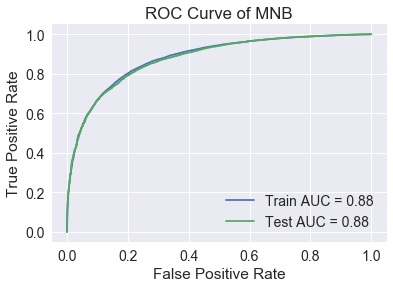

In [134]:
#Testing with test data
Train_FPR, Train_TPR, threshold = roc_curve(Y_Train, Optimal_Model.predict_proba(tfidf_sent_vectors_train)[:,1])
Test_FPR, Test_TPR, threshold = roc_curve(Y_Test, Optimal_Model.predict_proba(tfidf_sent_vectors_test)[:,1])
roc_auc6 = auc(Train_FPR, Train_TPR)
roc_auc7 = auc(Test_FPR, Test_TPR)

plt.plot(Train_FPR, Train_TPR, label = 'Train AUC = %0.2f' % roc_auc6)
plt.plot(Test_FPR, Test_TPR, label = 'Test AUC = %0.2f' % roc_auc7)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MNB')
plt.show()

### <font color = blue>[4.4.5]Train and Test Accuracy </font>

In [135]:
Training_Accuracy_tfidfw2v = Optimal_Model.score(tfidf_sent_vectors_train, Y_Train)
print('Training_Accuracy=%0.3f'%Training_Accuracy_tfidfw2v)
Training_Error_tfidfw2v = 1 - Training_Accuracy_w2v
print('Training_Error=%0.3f'%Training_Error_tfidfw2v)

Training_Accuracy=0.790
Training_Error=0.190


In [136]:
Test_Accuracy_tfidfw2v = accuracy_score(Y_Test, prediction)
print('Test_Accuracy=%0.3f'%Test_Accuracy_tfidfw2v)
Test_Error_tfidfw2v = 1 - Test_Accuracy_tfidfw2v
print('Test_Error=%0.3f'%Test_Error_tfidfw2v)
#print('\nThe accuracy of the MNB classifier for k = %d is %f%%' % (optimal_alpha_bow, Test_Accuracy_Bow))

Test_Accuracy=0.783
Test_Error=0.217


### <font color = blue>[4.4.6]Confusion Matrix </font>

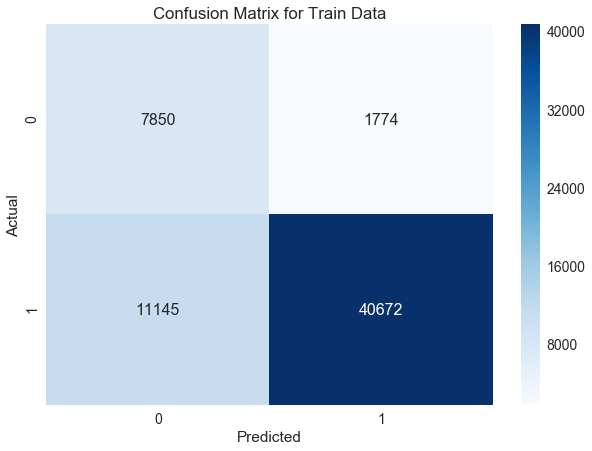

In [137]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Train, Optimal_Model.predict(tfidf_sent_vectors_train))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Train), index=np.unique(Y_Train))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Train Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

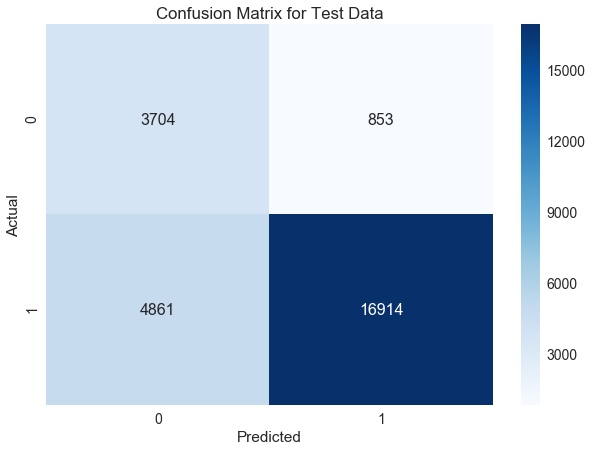

In [138]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_Test, Optimal_Model.predict(tfidf_sent_vectors_test))
df_conf_matrix = pd.DataFrame(conf_matrix, columns=np.unique(Y_Test), index=np.unique(Y_Test))
df_conf_matrix.index.name = 'Actual'
df_conf_matrix.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
plt.title("Confusion Matrix for Test Data")
sns.set(font_scale=1.4)
sns.heatmap(df_conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='d')

### <font color = blue>[4.4.7] Classification Report</font>

In [139]:
from sklearn.metrics import classification_report
print(classification_report(Y_Test, prediction))

             precision    recall  f1-score   support

          0       0.43      0.81      0.56      4557
          1       0.95      0.78      0.86     21775

avg / total       0.86      0.78      0.81     26332



## <font color = Blue>[4.4.8] Feature Importance </font>

### <font color = blue>Feature Importance for Positive and Negetive Class</font>	

In [140]:
show_most_informative_features(model, Optimal_Model)

________________________________________________________________________________________________
	Negative					Positive
________________________________________________________________________________________________
	-1.4927	aafco          				1.1328	aaaaa          
	-1.1375	aahing         				0.8360	abbey          
	-0.9563	aaaaaawwwwwwwwww				0.6794	abe            
	-0.8997	aback          				0.5305	aaa            
	-0.7332	abc            				0.5033	abide          
	-0.6642	abilities      				0.4619	abiding        
	-0.6094	ablaze         				0.3912	abandoning     
	-0.5975	aachen         				0.3488	aaaa           
	-0.5406	aaaah          				0.3482	abid           
	-0.5286	aarthur        				0.3314	aamazon        
	-0.5217	abdomen        				0.3127	abit           
	-0.4075	abbreviated    				0.2215	aaahs          
	-0.3518	abbott         				0.1671	abandon        
	-0.1843	abbreviation   				0.1368	abates         
	-0.1444	abandoned      				0.1365	abhors         
	-0.1349	aa      

## <font color = Green>Pretty Table</font>

In [149]:
from prettytable import PrettyTable
comparision = PrettyTable()
comparision.field_names = ["Vectorizer", "CV-AUC-L1", "CV-AUC-L2", "Training Error", "Test Error"]
comparision.add_row(["BoW", "0.952","0.956", np.round(float(Training_Error_Bow),3), np.round(float(Test_Error_Bow),3)])
comparision.add_row(["TF-IDF", "0.962", "0.966",np.round(float(Training_Error_Tfidf),3), np.round(float(Test_Error_Tfidf),3)])
comparision.add_row(["Word2Vec", "0.904", "0.904", np.round(float(Training_Error_w2v),3), np.round(float(Test_Error_w2v),3)])
comparision.add_row(["TF-IDF Weighted W2V", "0.879", "0.878", np.round(float(Training_Error_tfidfw2v),3), np.round(float(Test_Error_tfidfw2v),3)])
print(comparision)

+---------------------+-----------+-----------+----------------+------------+
|      Vectorizer     | CV-AUC-L1 | CV-AUC-L2 | Training Error | Test Error |
+---------------------+-----------+-----------+----------------+------------+
|         BoW         |   0.952   |   0.956   |      0.17      |   0.175    |
|        TF-IDF       |   0.962   |   0.966   |     0.345      |   0.348    |
|       Word2Vec      |   0.904   |   0.904   |      0.19      |   0.194    |
| TF-IDF Weighted W2V |   0.879   |   0.878   |      0.19      |   0.217    |
+---------------------+-----------+-----------+----------------+------------+


### <font color = Green>Conclusion</font>

1. Applied Logistic Regression on all the 4 vectorizers(BOW, TFIDF, AVG-W2V, TFIDF-AVG_W2V).
2. Sorted the data based on Time and Considered 100 K data points for Training set 70K, Test set: 30K. 
3. Used AUC as a metric for hyperparameter tuning. And took the range of lambda values between (10^-4 to 10^4).
4. Found the top 20 features of positive and negative class for the featurizations Bow and TF-IDF, TFIDF Weighted vector.
5. With reference to the pretty table, here is my understanding: 
    a. Logistic Regression by using TF-IDF featurization is having the best AUC score: 0.96.
    b. Logistic Regression by using BoW having AUC score: 0.95 and TF-IDF Weighted W2V is having the AUC Score: 0.87.
6. Class_Weight has set to 'balanced'
7. Pertubation test has performed and printed the multicollinearity features.